In [1]:
# install JAX using iPython magic command
# %pip install --upgrade pip && pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.integrate as si
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

# %env XLA_PYTHON_CLIENT_PREALLOCATE=false

# make sure NVIDIA_VISIBLE_DEVICES is not 'none'
%env

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


{'PATH': '/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
 'HOSTNAME': 'jupyter-kcollins9-40ucmerced-2eedu',
 'NVARCH': 'x86_64',
 'NVIDIA_REQUIRE_CUDA': 'cuda>=11.4 brand=tesla,driver>=418,driver<419 brand=tesla,driver>=440,driver<441 brand=tesla,driver>=450,driver<451 brand=tesla,driver>=460,driver<461',
 'NV_CUDA_CUDART_VERSION': '11.4.148-1',
 'NV_CUDA_COMPAT_PACKAGE': 'cuda-compat-11-4',
 'CUDA_VERSION': '11.4.3',
 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64',
 'NVIDIA_VISIBLE_DEVICES': 'GPU-405ed80d-a581-c86f-c9fb-6f4f8acf6d62',
 'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',
 'NV_CUDA_LIB_VERSION': '11.4.3-1',
 'NV_NVTX_VERSION': '11.4.120-1',
 'NV_LIBNPP_VERSION': '11.4.0.110-1',
 'NV_LIBNPP_PACKAGE': 'libnpp-11-4=11.4.0.110-1',
 'NV_LIBCUSPARSE_VERSION': '11.6.0.120-1',
 'NV_LIBCUBLAS_PACKAGE_NAME': 'libcublas-11-4',
 'NV_LIBCUBLAS_VERSION': '11.6.5.2-1',
 'NV_LIBCUBLAS_PACKAGE': 'l

<h1>Forward Problem</h1>

In [33]:
#########################################################
# computational paramters
#########################################################

# size of spatial domain
L = 15.0  # originally 10, increased by 50%

# number of real space grid points (for plotting)
numx = 1025

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32  # 32

# set time-step size
dt = 1e-2  # 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 21  # 20

tvec = np.arange(0, numts) * dt


Shape fourtox: (65, 1025)


In [ ]:
#########################################################
# utility variables
#########################################################

# vector of fourier mode indices
# fournvec = -numfour,...,0,...,numfour
fournvec = np.arange(-numfour, numfour + 1)

# matrix for converting Fourier representation to real space
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

print('Shape fourtox:', fourtox.shape)

In [58]:
len(np.zeros(0))

0

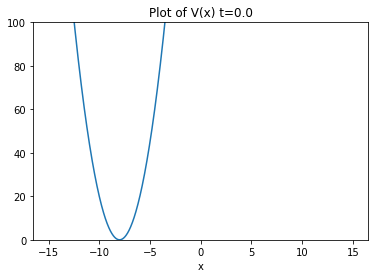

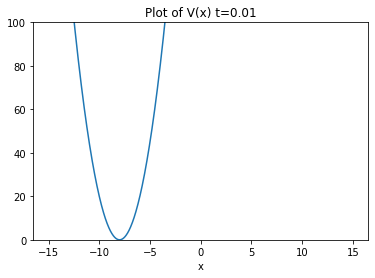

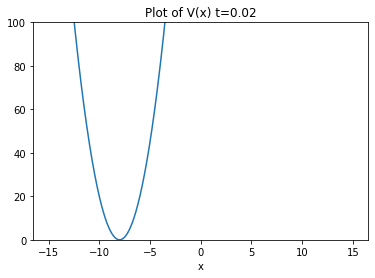

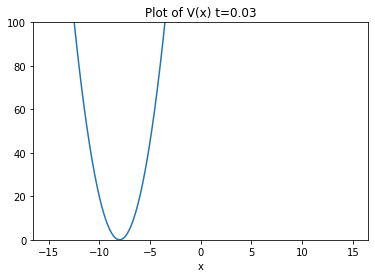

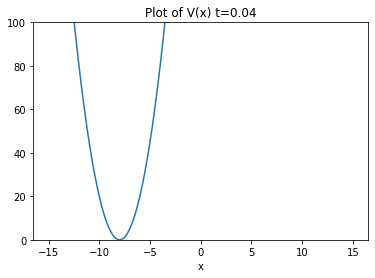

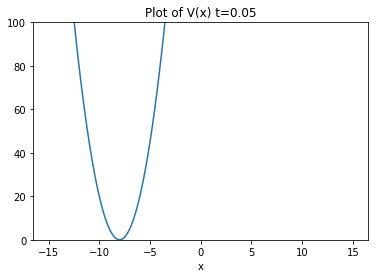

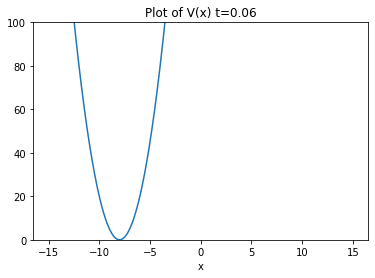

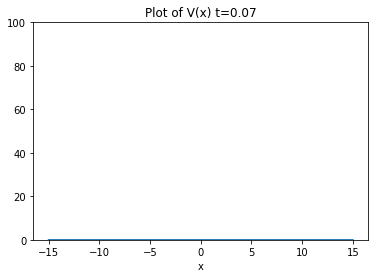

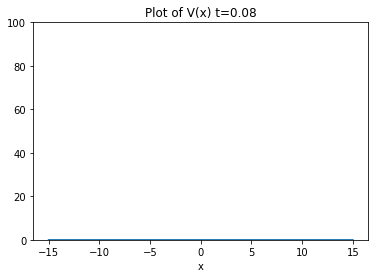

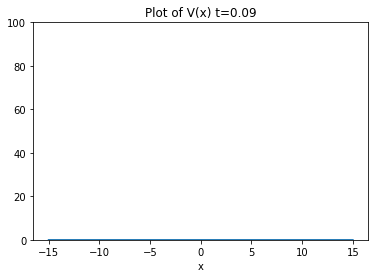

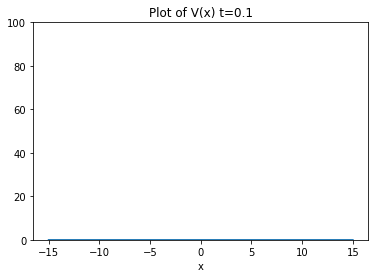

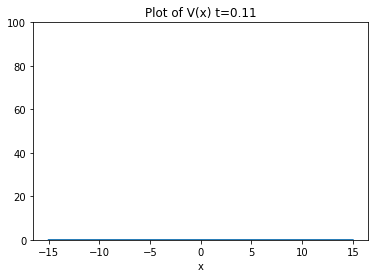

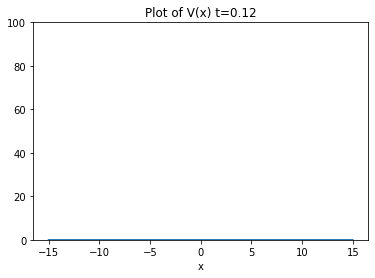

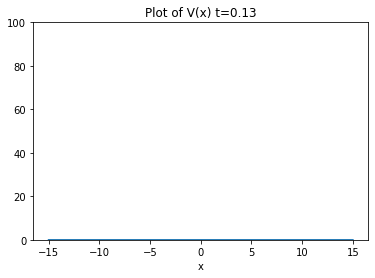

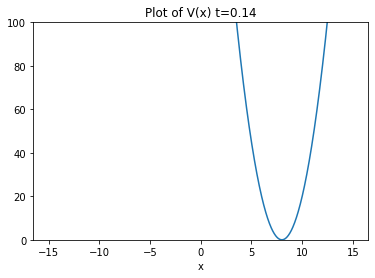

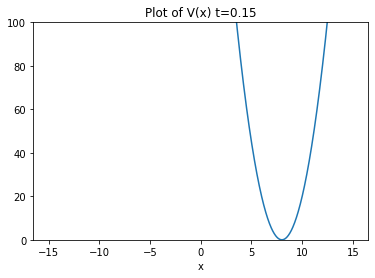

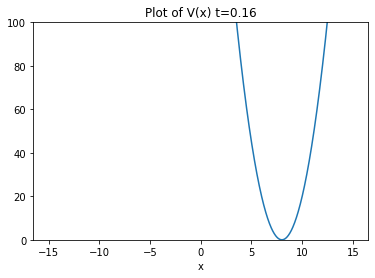

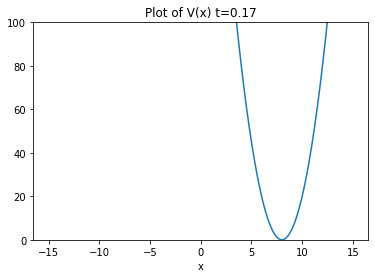

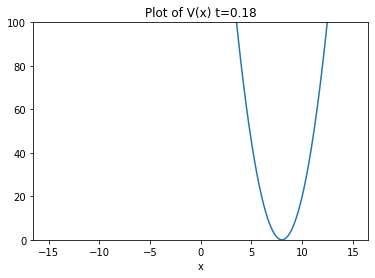

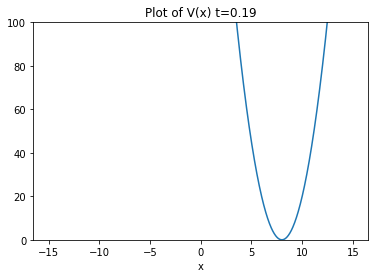

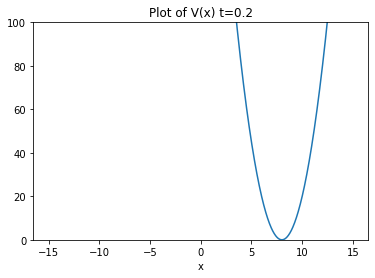

In [68]:
#########################################################
# potential
#########################################################

# start with a simple time dependent potential, one which is static
# for a set duration, but no two periods have the same potential

def v(t):
    if t < 7 * dt:
        return lambda z: 5.0 * (z + 8.0)**2
    elif t < 14 * dt:
        def rtnfn(z):
            # print(len(z))
            if type(z) == float:
                return 0.0
            else:
                # print('len > 1')
                return np.zeros(numx, dtype=float)
        return rtnfn
    else:
        return lambda z: 5.0 * (z - 8.0)**2

vvec = []
for thist in tvec:
    # get potential function for this time
    vvec.append(v(thist))

    # plot potential function for this time
    plt.plot(xvec, vvec[-1](xvec))
    plt.title(f'Plot of V(x) t={thist}')
    plt.ylim(0, 100)
    plt.xlabel('x')
    plt.show()

In [69]:
#########################################################
# these functions:
#   -   defines the initial real space state psi0, then
#   -   transform psi0 to the Fourier representation,
#       i.e., constructs a0
#########################################################


def psi0_0(x):
    return 10 * np.exp(-((x + 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return 10 * np.exp(-((x + 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-((x - 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_2(x):
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    return np.exp(-((x - 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    return np.exp(-((x + 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-((x - 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25

def psi0_5(x):
    return np.exp(-((x + 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions and transforming them to the Fourier representation

def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])

    a0 = jnp.array(a0)

    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


l2 error psi0_0: 7.476210590807997e-05
l-infinity error psi0_0: 3.137317008559103e-05


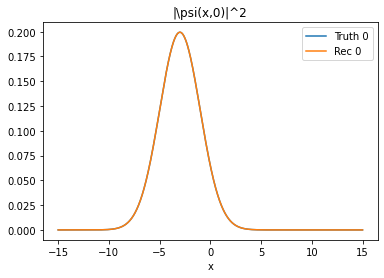

In [70]:
#########################################################
# construct vector a0vec
#########################################################

# pick initial un-normalized wave functions
psi0fnvec = [psi0_0]  # [psi0_0, psi0_1, psi0_2, psi0_3]  # [psi0_0, psi0_1, psi0_2, psi0_3, psi0_4, psi0_5]

a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)


# check if reconstructed Fourier representation is close to truth
for i in range(len(normpsi0xvec)):
    print(f'l2 error psi0_{i}:', nl.norm(normpsi0xvec[i] - normpsi0recxvec[i]))
    print(f'l-infinity error psi0_{i}:', np.max(np.abs(normpsi0xvec[i] - normpsi0recxvec[i])))
    # plot |\psi(x,0)|^2
    plt.plot(xvec, np.abs(normpsi0xvec[i])**2, label=f"Truth {i}")
    plt.plot(xvec, np.abs(normpsi0recxvec[i])**2, label=f"Rec {i}")

plt.title('|\psi(x,0)|^2')
plt.xlabel('x')
plt.legend()
plt.show()

---
**Forward Propagation**

In [71]:
#########################################################
# construct the kinetic operator in the Fourier
# representation (this is constant for a given system)
#########################################################

kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

In [73]:
#########################################################
# propagate a0 under the influence of the time-dependent
# potential
#########################################################

amattruevec = []
# propagate system starting from initial "a" state
for thisa0 in a0vec:

    # print('In a0 loop.')

    tempamat = [thisa0.copy()]

    for thist in tvec:
        # print('In t loop.')

        ### compute the potential operator matrix ###

        vtoeptrue = []
        for thisfourn in range(2 * numfour + 1):
            def intgrnd(x):
                return v(thist)(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
            def rintgrnd(x):
                return intgrnd(x).real
            def iintgrnd(x):
                return intgrnd(x).imag
            vtoeptrue.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

        vtoeptrue = jnp.array(vtoeptrue)
        # print('Shape vtoeptrue', vtoeptrue.shape)

        vmattrue = sl.toeplitz(r=vtoeptrue, c=np.conj(vtoeptrue))

        # print('Shape vmattrue:', vmattrue.shape)


        ### Eigendecomposition of Hamiltonian ###

        # Hamiltonian operator in the Fourier representation
        hmattrue = kmat + vmattrue

        # check if the Hamiltonian matrix is Hermitian
        # print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

        # eigen-decomposition of the Hamiltonian matrix
        spctrue, stttrue = jnl.eigh(hmattrue)

        # compute propagator matrix
        propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T

        tempamat.append(propatrue @ tempamat[-1])


    amattruevec.append(tempamat)


amattruevec = jnp.array(amattruevec)

print('Shape amattrue:', amattruevec.shape)

print('Done propagating')

Shape amattrue: (1, 22, 65)
Done propagating


In [74]:
# check if system's state remains normalized for the propagation

psimattruevec = amattruevec @ fourtox
print('Shape psimattrue:', psimattruevec.shape)

probmattruevec = np.abs(psimattruevec) ** 2
print('Shape probmattrue:', probmattruevec.shape)

normmattruevec = si.trapezoid(probmattruevec, xvec)
print('Shape normmattrue:', normmattruevec.shape)

# average deviation from 1
print('Average deviation from 1 of propgated wave function:', np.mean(np.abs(normmattruevec - 1.0)), sep='\n')

Shape psimattrue: (1, 22, 1025)
Shape probmattrue: (1, 22, 1025)
Shape normmattrue: (1, 22)
Average deviation from 1 of propgated wave function:
1.400258949195306e-10
